# Get drift statistics

The main mesurements we need are the average L2 distances between single-neuron tuning curves over time. First/second half of session, as well as even vs odd trials, should be included. We should use normalized, mean-centered, and trial-pseudotime aligned log-Calcium fluorescence traces. Tuning curves in fact have four parts, depending on the previous turn direction and the upcoming turn direction. This is more work than you'd think!  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocess as multi
try:
    multi.set_start_method('spawn')
except RuntimeError:
    print('couldn\'t set context')

##### Path configuration #####
# Location of Driscoll datasets on your system; Download from 
# https://datadryad.org/stash/dataset/doi:10.5061/dryad.gqnk98sjq
PPC_DATA_PATH = '/home/cfs/mer49/PPC_data/'
# Where to put cache for intermediate results
PY_CACHE_DIR  = './'
# Name of folder in which to cache intermediate processing results
CACHE_NAME    = 'cache'

# Add local libraries to path. A stripped-down copy of neurotools, and 
# some code for extracting the Driscoll datasets, is included. 
# https://github.com/michaelerule/neurotools/blob/master/README.md
import os,sys
sys.path.insert(0,os.path.abspath("./"))
sys.path.insert(0,os.path.abspath("./driscolldatatools/"))

# Pretty ugly: sets up disk caching for procssing Driscoll data
# Caching was useful for exploratory analysis, but is a bit too heavy
# for this paper. I will generate and save the intermediate results, 
# then comment out this code. 
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
from neurotools.tools import ensure_dir
ensure_dir(PY_CACHE_DIR+os.sep+CACHE_NAME)
initialize_caches(PY_CACHE_DIR,CACHE_IDENTIFIER=CACHE_NAME)
import neurotools
from   neurotools.nlab import *

# Import Driscoll et al. data wrangling libraries
import ppc_data_loader
ppc_data_loader.path = PPC_DATA_PATH
from ppc_data_loader  import *
from ppc_trial        import *

import config, master, standard_options, parallel
from config           import *
from master           import *
from standard_options import *
from parallel         import _parmap, helper, try_variations
# If running parallel jobs, limit cores/job to 1
# Disable logging (too verbose)
limit_cores()
debug = False
master.PRINT_LOGGING = False
mpl.rcParams['figure.dpi'] =200

# Calculate rate of drift

1. Use a greedy search to find a long span of sessions with sufficient units
2. Get pseudotime-aligned trial data for all units tracked across the given sessions
3. Get the mean-squared distance in these tuning curves as a function of Δ days
4. Plot, and estimate the drift rates and baseline variability

In [2]:
mice     = [1,3,4]
TIMERES  = 100  # pseudotime resolution
JITTER   = 25   # event time jitter tolerance
MINΔDAY  = 35   # desired minimum span of days
MINDAYS  = 15   # desired minimum number of sessions within in this span
LOWF     = 0.03 # filter cutoffs Hz
HIGHF    = 0.3  

from collections import defaultdict
from itertools import product as Π

def cψ(a,b):
    return mean(mean((a-mean(a,0))*(b-mean(b,0)),0)/(std(a,0)*std(b,0)))

@memoize
def get_aligned_logF_common(mouse,sessions,units):
    '''
    Bandpass filter log-fluorescence and align to trial pseudotime.
    '''
    results = defaultdict(list)
    tunings = {}
    goodsnr = {}
    for s in progress_bar(sessions):
        dff = get_dFF(mouse,s).T[units]
        lnf = log1p(maximum(-1.0+1e-6,dff))
        FS  = get_FS(mouse,s)
        y   = array([bandpass_filter(z,fa=LOWF,fb=HIGHF,Fs=FS) for z in lnf])
        z   = align_trials(mouse,[s],[y],PSTIMERES = TIMERES)[0]
        z   = (z-mean(z,1)[:,None,:])/std(z,1)[:,None,:]
        tunings[s] = z
        # signal > noise for at least 10% of locations
        goodsnr[s] = mean(abs(mean(z,0)/std(z,(0,1)))>0.5,0)>0.1
        # mean-squared Δ for even/odd trialsm 1st/2nd session half
        # Even/odd gives us our baseline variability
        results[0.00] += [cosψ(z[0::2]      , z[1::2]      )]
        results[0.50] += [cosψ(z[:len(z)//2], z[len(z)//2:])]
    return dict(results), tunings, goodsnr

def fitdrift(x,y):
    def objective(p,t,y):
        a,τ = p
        yhat = a*exp(-t/τ)
        return mean((y-yhat)**2)/2
    def gradient(p,t,y):
        a,τ = p
        yhat = a*exp(-t/τ)
        return [mean((y-yhat)*exp(-t/τ)),
                mean((y-yhat)*yhat*t/τ**2)]
    result = scipy.optimize.minimize(objective,[1,10],args=(x,y))#,method='Newton-CG',jac=gradient)
    print(result.message)
    print('Success=',result.success)
    a,τ = result.x
    print('a,τ=',a,τ)
    return a,τ

In [3]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)


Mouse 1
  using sessions [0, 1, 3, 4, 5, 6, 10, 14, 16, 23, 37, 45, 52, 54, 58]
  10 units
14                                                                    
Optimization terminated successfully.
Success= True
a,τ= 0.6294944279601433 56.96506956480309
  Drift timescale   : 56.96506956480309
  Vertical intercept: 0.6294944279601433
  Excess variability: 0.5885764124083961
Mouse 3
  using sessions [0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 15, 19, 21, 30, 35]
  60 units
9                                                                     
Optimization terminated successfully.
Success= True
a,τ= 0.6897500949485212 23.455203923906396
  Drift timescale   : 23.455203923906396
  Vertical intercept: 0.6897500949485212
  Excess variability: 0.44980045283594183
Mouse 4
  using sessions [3, 4, 5, 6, 9, 10, 11, 12, 13, 17, 20, 24, 25, 27, 38]
  83 units
11                                                                    
Optimization terminated successfully.
Success= True
a,τ= 0.7167149241906549 54

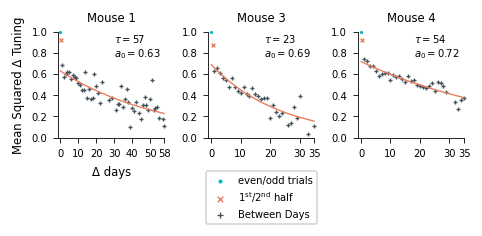

In [4]:
def cosψ(a,b):
    '''
    Get angle between tuning curves, accounting for measurement noise. 
    '''
    s = shape(a)
    if not len(s) in {2,3}:
        raise ValueError('Expected NLOC×NNEUR or NTRIAL×NLOC×NNEUR shape')
    if len(s)==2: return cψ(a,b)
    '''
    Estimate mean tuning curves; bootstrap correct estimator bias
    '''
    Na,Nb = a.shape[0],b.shape[0]
    sampa = lambda:np0.mean(a[choice(arange(Na),Na)],0)
    sampb = lambda:np0.mean(b[choice(arange(Nb),Nb)],0)
    ca    = np0.mean([cψ(sampa(),sampa()) for i in range(10)])
    cb    = np0.mean([cψ(sampb(),sampb()) for i in range(10)])
    return cψ(np0.mean(a,0), np0.mean(b,0)) / np0.sqrt(ca*cb)
    
mb = []
aτ = []
ax = {}
Zd = {}
used_sessions   = {}
saved_plot_data = {}
for im,mouse in enumerate(mice):
    
    # Pick a mouse and session, get tracked neurons
    sessions = get_session_ids(mouse)
    days     = get_days(mouse)
    days     = array(days)-np0.min(days)
    daymap   = dict(zip(sessions,days))
    NDAYS    = days[-1]
    NSESS    = len(sessions)
    daymap   = dict(zip(sessions,days))
    
    # Greedy optimize to maximize covered units
    best = {}
    included = set(sessions)
    for i in range(20):
        for ii in included:
            use   = included - {ii}
            if daymap[np0.max([*use])]-daymap[np0.min([*use])] >= MINΔDAY:
                units = get_units_in_common(mouse,use)[0]
                if (not i in best) or len(units)>best[i][0]:
                    best[i] = (len(units),use)
        if not i in best: break
        included = best[i][1]
        if len(included)==MINDAYS: break
    print('Mouse',mouse)
    print('  using sessions',sorted([daymap[s] for s in best[i][1]]))
    print('  %d units'%best[i][0])
    sessions = sorted([*included])
    used_sessions[mouse] = sessions
    units    = get_units_in_common(mouse,sessions)[0]
    results, tunings, goodsnr = get_aligned_logF_common(mouse, sessions, units)
    sdays    = [daymap[s] for s in sessions]
    print(np0.max(np0.diff(sdays)))
    
    # calculate average parwise differences across all days. 
    for s1,s2 in Π(sessions,sessions):
        if s1>=s2: continue
        Δd = daymap[s2]-daymap[s1]
        if not Δd in results: results[Δd]=[]
        results[Δd] += [cosψ(tunings[s1],tunings[s2])]
    keys = sorted(results.keys())
    Δ = [(d,mean(array(results[d]))) for d in keys]
    x,y = map(array,zip(*Δ))
    y   = y/y[0]
    m,b = np0.polyfit(x[2:],y[2:],1)
    a,τ = fitdrift(x[2:],y[2:])
    saved_plot_data[mouse] = (x,y,a,τ)
    print('  Drift timescale   :',τ)
    print('  Vertical intercept:',a)
    print('  Excess variability:',1/a-1)
    aτ += [(a,τ)]
    Zd[mouse] = mean(tunings[sessions[0]],0)

a , τ = map(array,zip(*aτ))
μa,μτ = mean(a),mean(τ)
print('Drift timescale   :',μτ)
print('Vertical intercept:',μa)
print('Excess variability:',1/μa-1)

figure(dpi=120,figsize=(4,2))
for im,mouse in enumerate(mice):
    x,y,a,τ = saved_plot_data[mouse]
    ax[im] = subplot(1,len(mice),im+1)
    scatter(x[:1] , y[:1] , marker='.', s=5, lw=0.8, color=TURQUOISE, label='even/odd trials')
    scatter(x[1:2], y[1:2], marker='x', s=5, lw=0.8, color=RUST,      label='$1^{\operatorname{st}}/2^{\operatorname{nd}}$ half')
    scatter(x[2:] , y[2:] , marker='+', s=5, lw=0.8, color=BLACK,     label='Between Days')
    plot(x,a*exp(-x/τ),lw=0.8,color=RUST)
    noclip()
    simpleaxis()
    if im==0: label('Δ days','Mean Squared Δ Tuning')
    title('Mouse %d'%mouse)
    ylim(0,1)
    xticks([*xticks()[0]][:-1]+[max(x)])
    xt = arange(0,60,10)
    xt = xt[xt<=max(x)-5]
    xticks(sorted([*xt]+[max(x)]),fontsize=6)
    xlim(-1,max(x))
    force_aspect()
tight_layout()
sca(ax[1])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.27), fancybox=True,ncol=1,fontsize=6,markerscale=1.5)
for i in range(len(mice)): 
    sca(ax[i])
    label = '$τ=%0.0f$'%saved_plot_data[mice[i]][3]
    label+= '\n$a_0=%0.2f$'%(saved_plot_data[mice[i]][2])
    text(xlim()[1]-px2x(50),ylim()[1]-px2y(3),label,
        fontsize=6,
        va='top',
        ha='left')  

# Calibrate features to match

Optimization terminated successfully.
Success= True
a,τ= 0.6748982750084529 40.031232511712524
μa,μτ= 0.679 44.953
 a, τ= 0.675 40.031


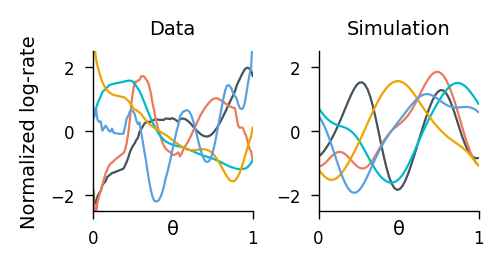

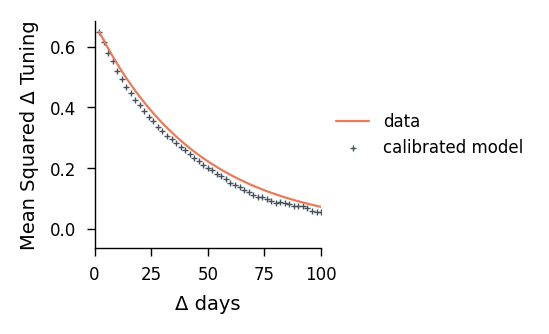

In [5]:
opts = {**options,
    'seed'     :1,     # Random seed to use
    'linearize':True,  # Remove nonlinearity on encoding features?
    'τ' :225   ,       # Correlation time of random drift
    'r' :0.3   ,       # Per-timepoint independent encoding variability
}
globals().update(opts) # Apologies; quick hack to load the defaults
X = get_features(L,K,T,P,σ*L,τ,features,geometry,seed)
X = prepare_features(X,σ*L,r,geometry,seed,linearize)
X0 = X
z = Zd[3]
NSHOW = 5
NZ    = shape(z)[-1]
NSHOW = np0.min([NSHOW, NZ])

figure(figsize=(2.5,1.5))
subplot(121)
title('Data')
show = np0.random.choice(arange(NZ),NSHOW,replace=False)
plot(linspace(0,1,TIMERES), zscore(z,0)[:,show],lw=.8);
simpleaxis(); ylim(-2.5,2.5); force_aspect(); xlabel('θ'); nicex()
ylabel('Normalized log-rate')

subplot(122)
title('Simulation')
show = np0.random.choice(arange(options['K']),NSHOW,replace=False)
plot(linspace(0,1,options['L']),zscore(X[0,show,:].T,0),lw=.8);
simpleaxis(); ylim(-2.5,2.5); force_aspect(); xlabel('θ'); nicex();
tight_layout()

# X is NDAYS × NNEURONS+1 × NLOCATIONS
# nmsd(...) expects NTRIALS × NLOCATIONS × NNEURONS
NT    = X.shape[0]
times = arange(0,X.shape[0],10)
Δs    = defaultdict(list)
for t1,t2 in Π(times,times):
    if t1<t2: Δs[t2-t1] += [cosψ(X[t1,:-1].T,X[t2,:-1].T)]

DMAX   = 100
NMATCH = 10
x,y    = array([[k,np0.mean(v)] for k,v in Δs.items() if len(v)>0]).T
order  = argsort(x)
x,y    = x[order], y[order]
x      = x/options['Δ']
a,τ    = fitdrift(x[2:],y[2:])
modelplotdata = (x,y,μa,μt)

figure(figsize=(2,1.5))
scatter(x,y,marker='+',s=4,lw=.5, label='calibrated model')
plot(x, μa*exp(-x/μτ), lw=0.8, color=RUST , label='data' )
simpleaxis(); xlim(0,DMAX); xlabel('Δ days'); ylabel('Mean Squared Δ Tuning'); force_aspect()
xticks([0,25,50,75,100],fontsize=6)
rightlegend()
modelstats = (a,options['τ']/options['Δ'])

print('μa,μτ= %0.3f %0.3f'%(μa,μτ))
print(' a, τ= %0.3f %0.3f'%( a, τ))

Shuffling job sequence
Parallel using 20 cores
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

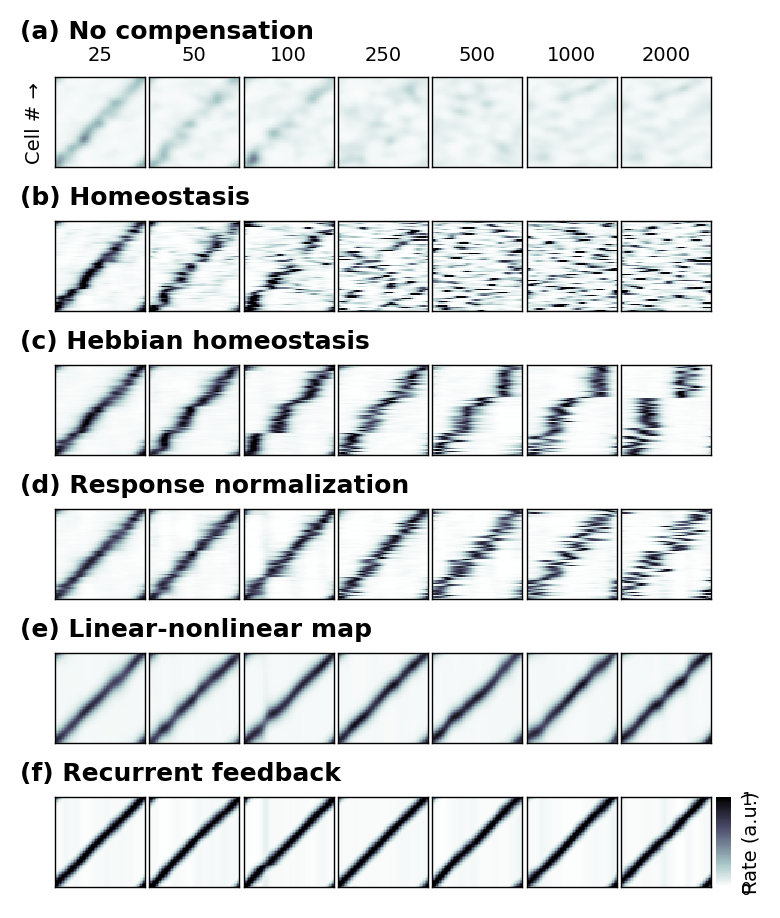

In [6]:
opts.update({
    'saveall'  :True,
    'linearize':False,          # Remove nonlinearity on encoding features?
    'T':opts['τ']*10+opts['Δ'], # Number of "days" to simulate
    'seed':2 # Sanity check: still works with different seeds?
})
pop_homeostat, pop_hebbhomeo, pop_normalize, pop_recurrent, pop_predictive = _parmap(helper,[
    {**opts,'method':'homeostat' ,'normalize':False,**rates['homeostat' ]},
    {**opts,'method':'hebbhomeo' ,'normalize':False,**rates['hebbhomeo' ]},
    {**opts,'method':'hebbhomeo' ,'normalize':True ,**rates['hebbhomeo' ]},
    {**opts,'method':'recurrent' ,'normalize':True ,**rates['recurrent' ]},
    {**opts,'method':'predictive','normalize':True ,**rates['predictive']},
],debug=True)
W0,X,Y0,Y,W,R,G,B = pop_homeostat
tt = arange(options['Δ']-1,options['T'],options['Δ'])
λ0 = sexp(einsum('km,tkl->tml',W0,X[tt,:,:]))
λh = pop_homeostat [3]
λb = pop_hebbhomeo [3]
λc = pop_normalize [3]
λr = pop_recurrent [3]
λp = pop_predictive[3]
λ0,λh,λb,λc,λr,λp = map(np.array,(λ0,λh,λb,λc,λr,λp))
vmin,vmax = 0,.05
dx  ,dy   = 35,15
nsnaps,M,L= shape(λ0)
ishow     = int32([25, 50, 100, 250, 500, 1000, 2000])
nrow,ncol = 5,len(ishow)
Δ,T,K     = options['Δ'],options['T'],options['K']

todo = [
    (λ0,'No compensation'       ),
    (λh,'Homeostasis'           ),
    (λb,'Hebbian homeostasis'   ),
    (λc,'Response normalization'),
    (λr,'Linear-nonlinear map'  ),
    (λp,'Recurrent feedback'    )]
# Plot
vmin,vmax = 0,.05
dx  ,dy   = 35,15
nsnaps,M,L= shape(λ0)
nrow,ncol = 6,len(ishow)
figure(figsize=(4,4.8),dpi=200)
subplots_adjust(top=0.9,wspace=0.05,bottom=0.025,right=0.9,left=0.08)
for c,i in enumerate(ishow):
    for r,(λ,name) in enumerate(todo):
        subplot(nrow,ncol,c+ncol*r+1)
        imshow(λ[i//Δ,:,:],vmin=vmin,vmax=vmax); 
        nox(); noy(); force_aspect()
        if c==0:
            subfigurelabel('(%s) '%('abcdef'[r])+name,fontsize=9,dx=dx,dy=dy+
                          (30 if r==0 else 0))
        if r==0:
            title('%d'%((i//Δ)*Δ))
            if c==0:
                ylabel('Cell # →')
good_colorbar(0,1,'bone_r','Rate (a.u.)',fontsize=7);

# Master Figure 

In [7]:
def subplotB(ax):
    sca(ax)
    x,y,μa,μt = modelplotdata
    scatter(x,y,marker='+',s=4,lw=.5)
    title('Model')
    plot(x, μa*exp(-x/μτ), lw=0.8, color=RUST)
    simpleraxis()
    xlabel('Δ days')
    ylim(0,1)
    yticks([0,1])
    xticks([0,10,20,35],fontsize=6)
    xlim(-2,35)
    plot([0,35],[0,0],color='k',lw=0.8, clip_on=False)
    ax.tick_params(axis='both', which='both', length=2)
    force_aspect()
    a,τ = modelstats
    label = '$τ=%0.0f$'%τ
    label+= '\n$a_0=%0.2f$'%(a)
    text(xlim()[1]-px2x(50),ylim()[1]-px2y(3),label,
        fontsize=6, va='top', ha='left')  

import copy as cpy
    
def subplotA(ax):
    for im,mouse in enumerate(mice):
        x,y,a,τ = saved_plot_data[mouse]
        sca(ax[im])
        scatter(x[:1] , y[:1] , marker='.', s=5, lw=0.8, color=TURQUOISE,
                label='Same day, even/odd trials')
        scatter(x[1:2], y[1:2], marker='x', s=5, lw=0.8, color=RUST,
                label='Same day, $1^{\operatorname{st}}/2^{\operatorname{nd}}$ half')
        scatter(x[2:] , y[2:] , marker='+', s=5, lw=0.8, color=BLACK,
                label='Between different days')
        plot(x,a*exp(-x/τ),lw=0.8,color=RUST)
        noclip()
        simpleraxis()
        if im==0:
            xlabel('Δ days')
            ylabel('Tuning\nAlignment')
        title('Mouse %d'%mouse)
        ylim(0,1)
        yticks([0,1],['0','1'] if im==0 else ['',''])
        xticks([*xticks()[0]][:-1]+[max(x)])
        xt = arange(0,60,10)
        xt = xt[xt<=max(x)-9]
        xticks(sorted([*xt]+[max(x)]),fontsize=6)
        xlim(-2,max(x))
        plot([0,max(x)],[0,0],color='k',lw=0.8, clip_on=False)
        gca().tick_params(axis='both', which='both', length=2)
        force_aspect()
        label = '$τ=%0.0f$'%τ
        label+= '\n$a_0=%0.2f$'%(a)
        text(xlim()[1]-px2x(50),ylim()[1]-px2y(3),label,
            fontsize=6, va='top', ha='left')  
    sca(ax[1])
    legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.27),
           fancybox=True,
           ncol=1,
           fontsize=6,
           markerscale=1.5,
           edgecolor=(1,1,1,0))
    
def subplotD(ax):
    W0,X,Y0,Y,U,R,G,B = pop_homeostat
    tt = arange(options['Δ']-1,options['T'],options['Δ'])
    λ0 = sexp(einsum('km,tkl->tml',W0,X[tt,:,:]))
    λh = pop_homeostat[3]
    λb = pop_hebbhomeo[3]
    λc = pop_normalize[3]
    λr = pop_recurrent[3]
    λ0,λh,λb,λc,λr = map(np.array,(λ0,λh,λb,λc,λr))
    vmin,vmax = 0 ,.05
    dx  ,dy   = 35, 15
    nsnaps,M,L= shape(λ0)
    for j,i in enumerate(ishow):
        ax[0,j]=subplot2grid(plotgridshape,(0,4+j))
        imshow(λb[i//Δ,:,:],vmin=vmin,vmax=vmax); nox(); noy(); force_aspect()
        title('%d'%((i//Δ)))
        if j==0:
            ylabel('Hebbian\nhomeostasis')
            text(0,ylim()[1]+16,'# Simulated Days →',fontsize=7)
        ax[1,j]=subplot2grid(plotgridshape,(1,4+j))
        imshow(λc[i//Δ,:,:],vmin=vmin,vmax=vmax); nox(); noy(); force_aspect()
        if j==0:
            ylabel('Response\nnormalization')
        ax[2,j]=subplot2grid(plotgridshape,(2,4+j))
        imshow(λr[i//Δ,:,:],vmin=vmin,vmax=vmax); nox(); noy(); force_aspect()
        if j==0:
            ylabel('Linear-\nnonlinear map')
        ax[3,j]=subplot2grid(plotgridshape,(3,4+j))
        imshow(λp[i//Δ,:,:],vmin=vmin,vmax=vmax); nox(); noy(); force_aspect()
        if j==0:
            ylabel('Recurrent\nfeedback'); 
        elif j==2:
            xlabel('← $\\theta$ →',labelpad=2)
            ylabel('Cell # →',labelpad=2)
            gca().yaxis.set_label_position("right")

def subplotC(ax1,ax2,ax3,ax4):
    # Tuning curves from data
    sca(ax1)
    show = np0.random.choice(arange(z.shape[1]),NSHOW,replace=False)
    plot(linspace(0,1,TIMERES), zscore(z,0)[:,show],lw=.8);
    ylim(-2.5,2.5)
    simpleaxis(); 
    force_aspect()
    noy()
    xticks([0,1],['',''])
    # Tuning curves from model
    sca(ax2)
    show = np0.random.choice(arange(options['K']),NSHOW,replace=False)
    plot(linspace(0,1,options['L']),zscore(X0[0,show,:].T,0),lw=.8);
    ylim(-2.5,2.5)
    noy()
    simpleaxis(); force_aspect()
    xlabel('θ'); 
    ylabel('Log-Rate\n(Normalized)')
    fudgex(7.5)
    nicex()
    current_cmap = cpy.copy(matplotlib.cm.get_cmap('bone_r'))
    current_cmap.set_bad((0.85,)*3)
    set_cmap(current_cmap)
    mouse    = 4
    sessions = get_session_ids(mouse)[:-1]
    units    = get_units_in_common(mouse,sessions)[0]
    results, tunings, goodsnr = get_aligned_logF_common(mouse, sessions, units)
    μt = array([zscore(mean(t - mean(t,(0,1)),0),0) for d,t in tunings.items()])
    d  = get_days(mouse)[:-1]
    ncells = shape(μt)[2]
    u = np0.zeros((d[-1],TIMERES,ncells))+NaN
    for i,d in enumerate(d):
        u[d-1] = exp(μt[i])
    # Example feature from data
    sca(ax3)
    imshow(u[:,:,6].T,cmap=current_cmap,aspect='auto')
    noxyaxes()
    title('Tuning over time →',loc='left')
    # Example feature from model
    sca(ax4)
    i = randint(100)
    j = randint(ncells)
    imshow(X[:Δ*shape(u)[0]:Δ,6,:].T,cmap=current_cmap,aspect='auto')
    noxyaxes()
    ylabel('← θ →')
    xticks([0,shape(u)[0]-1],['1',str(shape(u)[0])])
    xlabel('Day')
    fudgex(7.5)

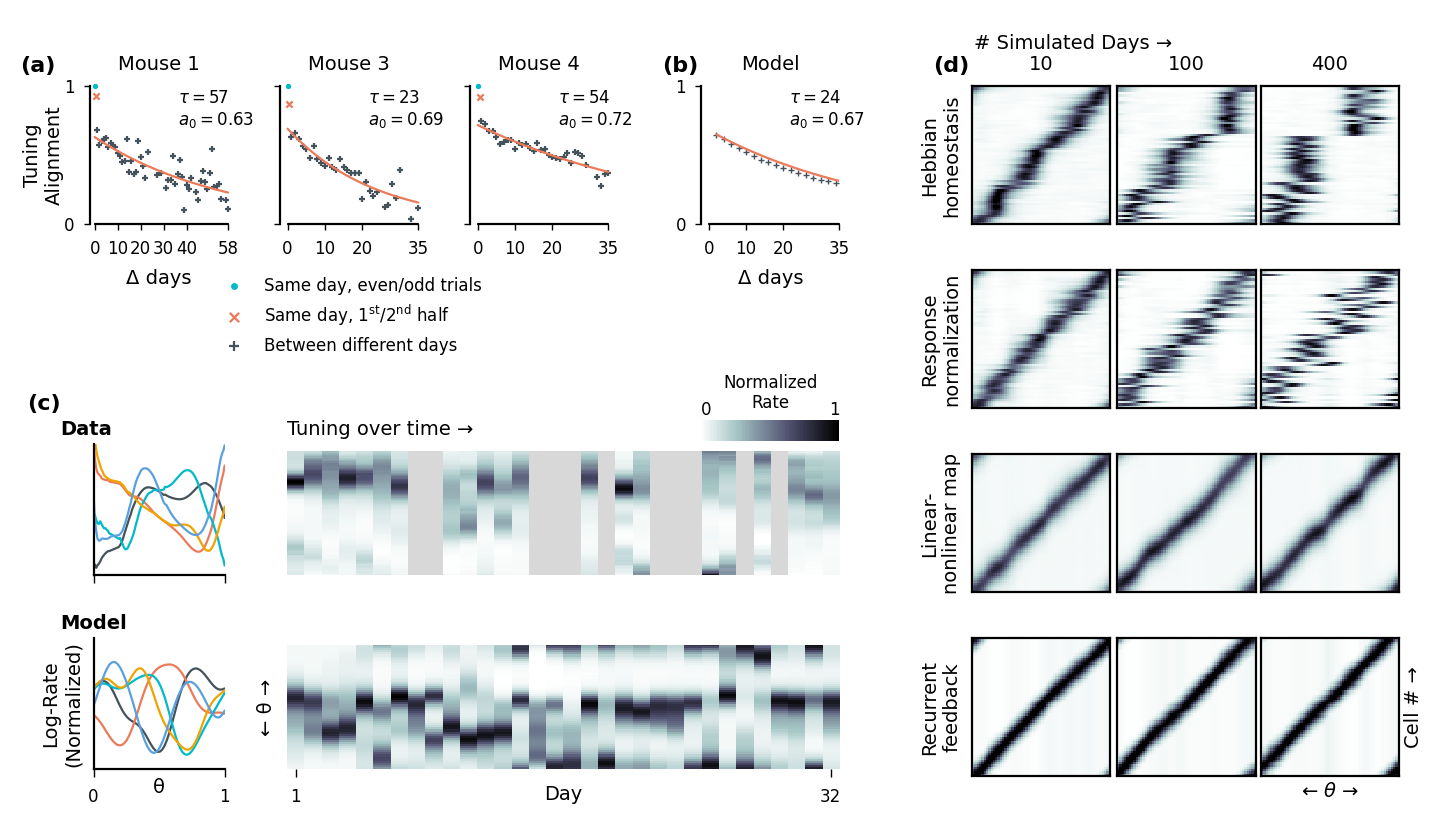

In [8]:
mpl.rcParams['axes.linewidth'] = 0.8
FIGURE_HEIGHT_INCHES = 0.393701 * 10
figure(figsize=(PNAS_LARGE_WIDTH, FIGURE_HEIGHT_INCHES),facecolor='w', dpi=200)

ishow = int32([50, 500, 2000])
NCOLS = len(ishow)
plotgridshape = (4,4+NCOLS)
ax = {
    'a1':subplot2grid(plotgridshape,(0,0)),
    'a2':subplot2grid(plotgridshape,(0,1)),
    'a3':subplot2grid(plotgridshape,(0,2)),
    'b' :subplot2grid(plotgridshape,(0,3)),
    'c1':subplot2grid(plotgridshape,(2,0)),
    'c2':subplot2grid(plotgridshape,(3,0)),
    'c3':subplot2grid(plotgridshape,(2,1),colspan=3),
    'c4':subplot2grid(plotgridshape,(3,1),colspan=3),
    'cb':subplot2grid(plotgridshape,(1,3)),
}
def q():
    subplots_adjust(
        left   = 0.05,
        bottom = 0.01,
        right  = 1.035,
        top    = 0.945,
        wspace = 0.5,
        hspace = 0.0)

q()
subplotA([ax['a1'],ax['a2'],ax['a3']])
subplotB(ax['b'])
subplotC(ax['c1'],ax['c2'],ax['c3'],ax['c4'])
subplotD(ax)

fudgey(-0,ax['a1'])
nudge_axis_x(-17,ax['a2'])
nudge_axis_x(-34,ax['a3'])
nudge_axis_x(-10,ax['b' ])
[nudge_axis_x(54,ax[i,0])      for  i in range(4)]
[nudge_axis_x(-8,ax[i,1])      for  i in range(4)]
[nudge_axis_x(-72,ax[i,2])     for  i in range(4)]
[nudge_axis_y(10,ax[ai])       for ai in ['c1','c3']]
[nudge_axis_baseline(7,ax[ai]) for ai in ['c1','c2']]
for ai in ['c3','c4']:
    sca(ax[ai])
    nudge_axis_baseline(60)
    nudge_axis_y(-30)
    nudge_axis_x(-10)
sca(ax['cb'])
nudge_axis_baseline(60)
nudge_axis_y(-70)
nudge_axis_x(-10)
noxyaxes()
imshow([linspace(0,1,100)])
xlim(0,100)
ylim(0,3  )
text(50,.8,'Normalized\nRate',ha='center',fontsize=6)
text(0  ,0.5+px2y(6),'0',ha='left' )
text(100,0.5+px2y(6),'1',ha='right')
sca(ax['a1']); subfigurelabel('(a)'  ,fontsize=8,dy=10,dx=70)
sca(ax['b' ]); subfigurelabel('(b)'  ,fontsize=8,dy=10)
sca(ax['c1']); subfigurelabel('(c)'  ,fontsize=8,dy=30,dx=70)
sca(ax[0,0 ]); subfigurelabel('(d)'  ,fontsize=8,dy=10)
sca(ax['c1']); subfigurelabel('Data' ,fontsize=7,dy=5,dx=35)
sca(ax['c2']); subfigurelabel('Model',fontsize=7,dy=5,dx=35)
figurebox('w')
savefigure('s3',stamp=False)

In [9]:
notify('ZXCV')

<IPython.core.display.Javascript object>

# Caption 

We calibrated a model of simulated drift using three subjects from the Driscoll et al. (2017) dataset. For each subject (M1, M3, and M4), we selected a subset of fifteen recording sessions sharing common neurons (N=10, 60, and 83 neurons from M1, M3, and M4 respectively). Each subpopulation was tracked for over a month (58, 35, and 38 days respectively), with modest gaps between consecutive recording sessions (no more than 13, 8, and 10 consecutive missing days, respectively). For each recording day, we filtered log-Calcium fluorescence traces between 0.03 and 0.3 Hz and normalized them by z-scoring. We extracted the filtered traces from sucessful trials, and aligned them to task pseudotime ("$\theta$") based on progress through the T-maze. These traces were averaged to estimate neuronal tuning curves. 

The tuning curves can be interpreted as vectors in a high-dimensional space, with a different component for each location $\theta$. We used the cosine of the angle $\psi$ between two tuning curves as an "alignment" measure to quantify drift (Supplmental Figure S9-a). This can be computed as the average product $\cos(\psi) = {\langle {\tilde x}_1(\theta) {\tilde x}_2(\theta) \rangle}_\theta$ between normalized (z-scored) tuning curves $\tilde x_i(\theta)$, and is 1 if the tuning curves are identical, and 0 (on expectation) if they are unrelated. This estimator is biased by measurement noise and trial-to-trial variability. We estimated this bias by sampling the expected alignment between two tuning curves from the same cell and day, where each tuning curve is estimated as an average of a different random subsets of trials. This baseline was calculated separately for each neuron and day, and averaged over ten random samples. We divided the tuning-curve alignment measure by this baseline to remove the bias from noise and inter-trial variability. Note that this retains excess per-day variability that cannot be explained by drift, noise, or trial-to-trial fluctuations. 

Alignment decayed exponentially over time; Its time constant ($\tau$) and extrapolated value at $Delta$ = 0 days ($a_0$) indicate the drift rate and excess per-day variability, respectively. We estimated these parameters using least-squares exponential regression (Figure S?-?). Results were similar across subjects ($\tau$ = 57, 23, 54; $a_0$ = 0.63, 0.69, 0.72; for M1, M3, M4 respectively), and we used the average values of these parameters across subjects ($\bar\tau$ = 45 and ${\bar a}_0$ = 0.68) to calibrate a model of drift (Figure S9-b). 

This calibration does not provide all the information needed for a principled comparison between simulations and experiments. However, it seems reasonable to conjecture that among the $>$ 10,000 synaptic inputs to a given pyramidal cell, there is sufficient redundancy to recover a readout with accuracy comparable to the 100 idealized encoding units considered here. Comparing simulation and experiment also requires assumptions about the frequency of "self-healing" reconsolidation, relative to the drift rate. In our simulations we apply self-healing every $\Delta$ = 5 timepoints. If we assume that "self-healing" occurs once per day *in vivo*, then an excess per-timepoint variability of $r \approx$ = 76\% and a time constant of $\tau$ = 45 ``days'' matches the simulated drift to the Driscoll et al. (2017) data. Speaking extremely loosely, this implies approximate stability out to $\approx$ 10 days using redundancy alone (fixed readout weights), a few months using Hebbian homeostasis, and more than one year if the readout contains a stable internal model. However, a precise test of how these ideas manifest *in vivo* would require new experimental studies.